#**Машинное обучение ИБ-2024**

#**Домашнее задание 3.**
#Классификация текстов, методы обучения без учителя.

**Все выводы ячеек вашей сданной работы должны оставаться в сданном ноутбуке, результаты должны быть видны. В противном случае 0 за задание!**

## Классификация текстов.

В этой части домашней работы Вам требуется реализовать полный пайплайн работы с текстами и моделями машинного обучения. От предобработки до запуска обучения моделей для задачи классификации.

**Задачи**:
1. Предобработка - Вам необходимо в представленных текстах избавиться от пунктуации, чисел и стоп-слов (nltk stopwords), привести тексты к нижнему регистру.
2. Сделать на Вашем корпусе очищенных текстов Лемматизацию или Стемминг. При этом словестно пояснить, что делает метод.
3. Разбить полученный датасет на train и test выборки в отношении 4:1
4. Привести ваши тексты из датасета к векторному формату. Тут необходимо попробовать два метода, разобранных на семинаре: Bag of words и TF-IDF. При этом словестно пояснить, что делает метод.
5. Провести кросс-валидация на подбор гиперпараметров моделей (GridSearchCV) и обучить модели: Логистическая регрессия, Random Forest, Gradient Boosting из CatBoost или XGBoost или LightGBM. (В данном задании не стоит "упарываться" в подбор гиперпараметров и считать каждую модель по 10 часов, покажите в коде, что Вы перебирали по сетке 2-3 гиперпараметра в разумном по времени интервале).
6. Замерьте метрики accuracy, precision, recall, F1-Score, ROC-AUC. Постройте ConfusionMatrix, сделайте анализ решения.

Все пункты задания весят по 1 Баллу. То есть за данный раздел можно получить максимум 6 Баллов.

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import nltk
import bcubed
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from numpy.linalg import det, inv
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# Загрузка необходимых ресурсов NLTK
nltk.download('punkt')
nltk.download('stopwords')

# Загрузка данных
df = pd.read_csv("combined_data.csv", encoding="utf-8", engine="c", on_bad_lines='skip')

# Просмотр первых строк данных
print(df.head())

# Предполагаем, что столбец 'label' содержит истинные метки, а 'text' содержит текстовые данные
# Если названия столбцов отличаются, замените их соответствующим образом
labels = df["label"].values
texts = df["text"].astype(str).values  # Приведение всех данных к строковому типу

# Векторизация текста с использованием TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(texts)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


   label                                               text
0      1  ounce feather bowl hummingbird opec moment ala...
1      1  wulvob get your medircations online qnb ikud v...
2      0   computer connection from cnn com wednesday es...
3      1  university degree obtain a prosperous future m...
4      0  thanks for all your answers guys i know i shou...


## Обучение без учителя

Сгенерируем смесь Гауссовских распределений. Эти данные Вам необходимо будет далее кластеризировать с помощью различных алгоритмов  кластеризации. Во всех заданиях Вам необходимо отрисовывать кластеры, которые Вы получили в результате работы моделей (графики, оси должны быть подписаны).

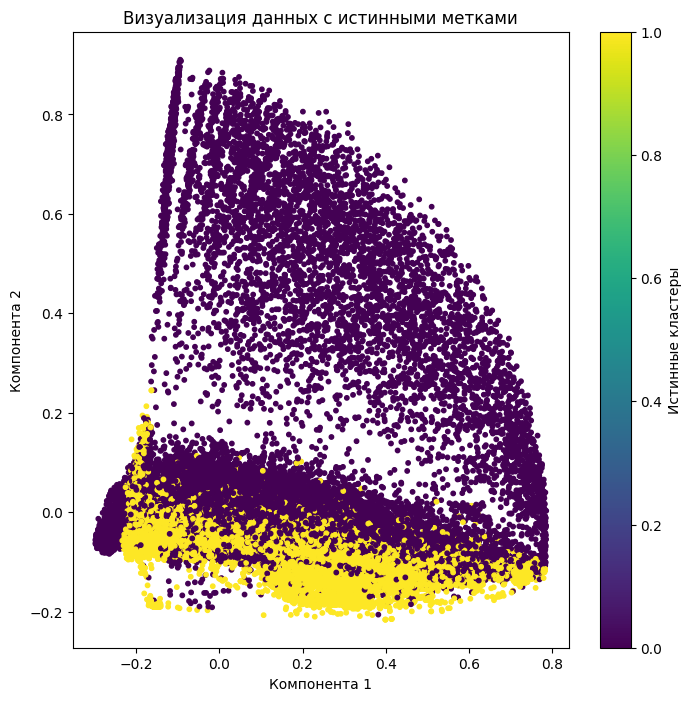

In [2]:
# Преобразование TF-IDF матрицы в плотный формат для PCA
X_dense = X.toarray()

# Применение PCA для снижения размерности до 2 компонентов
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_dense)

# Визуализация исходных данных с истинными метками
plt.figure(figsize=(8, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=10)
plt.title("Визуализация данных с истинными метками")
plt.xlabel("Компонента 1")
plt.ylabel("Компонента 2")
plt.colorbar(scatter, label="Истинные кластеры")
plt.show()

**Задание 1 [1 Балл].** Заиспользуйте метод K-Means для кластеризации полученной смесси Гауссовских распределений. Подберите гиперпараметр K максимизируя метрику индекс Силуэта (Silhouette Coefficient).

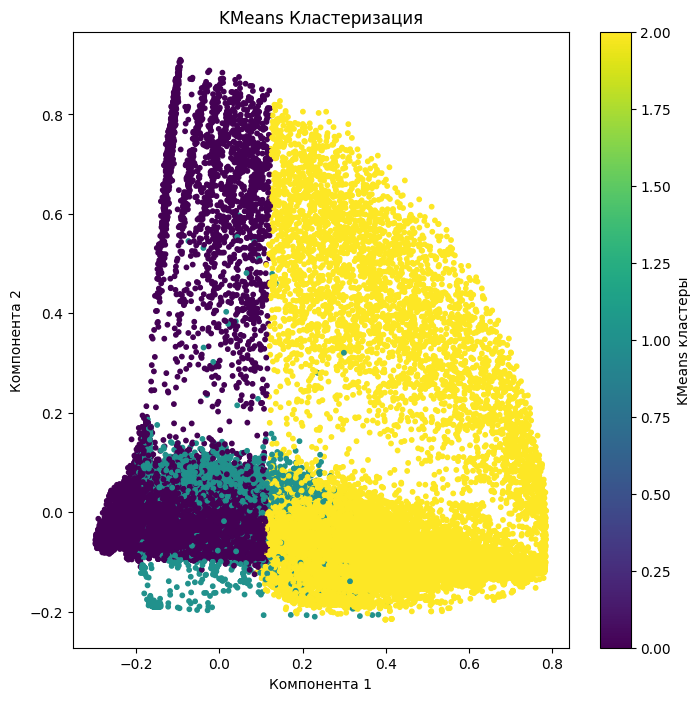

KMeans Silhouette Score: 0.05


In [5]:
# только 10k строк случайно:
df_sampled = df.sample(n=1000, random_state=42)
texts_sampled = df_sampled["text"].astype(str).values
labels_sampled = df_sampled["label"].values

# KMeans кластеризация
kmeans = KMeans(n_clusters=3, random_state=42)  # Замените n_clusters на нужное количество кластеров
kmeans_labels = kmeans.fit_predict(X_dense)

# Визуализация результатов KMeans
plt.figure(figsize=(8, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', s=10)
plt.title("KMeans Кластеризация")
plt.xlabel("Компонента 1")
plt.ylabel("Компонента 2")
plt.colorbar(scatter, label="KMeans кластеры")
plt.show()

kmeans_silhouette = silhouette_score(
    X_dense,
    kmeans_labels,
    sample_size=1000,       # Размер подвыборки для оценки (можно изменить по необходимости)
    random_state=42,        # Для воспроизводимости результатов
    metric='euclidean',     # Метрика расстояния
    n_jobs=-1               # Использование всех доступных ядер процессора для ускорения
)
print(f"KMeans Silhouette Score: {kmeans_silhouette:.2f}")

**Задание 2 [1 Балл].** Заиспользуйте метод DBSCAN для кластеризации полученной смесси Гауссовских распределений. Подберите гиперпараметры eps, min_samples максимизируя метрику BCubed (золотой стандарт записан в переменной labels).

In [14]:
import bcubed

def convert_to_bcubed_format(labels_array):
    """
    labels_array: numpy array с целочисленными метками.
    Возвращает словарь вида: {индекс_точки: {метка}, ...}
    """
    return {i: {label} for i, label in enumerate(labels_array)}

def bcubed_fscore(true_labels, pred_labels):
    # Конвертируем в формат bcubed
    true_dict = convert_to_bcubed_format(true_labels)
    pred_dict = convert_to_bcubed_format(pred_labels)
    precision = bcubed.precision(true_dict, pred_dict)
    recall = bcubed.recall(true_dict, pred_dict)
    return bcubed.fscore(precision, recall)

# Основной код
eps_values = [0.2, 0.5, 0.8, 1.0]
min_samples_values = [3, 5, 10]
best_fscore = -1
best_params = (None, None)

for eps_ in eps_values:
    for min_samp in min_samples_values:
        dbscan_model = DBSCAN(eps=eps_, min_samples=min_samp, n_jobs=-1)
        pred_labels = dbscan_model.fit_predict(X_dense)

        # Вычисляем BCubed F-score, преобразовав numeric labels в формат bcubed
        fscore = bcubed_fscore(labels, pred_labels)
        if fscore > best_fscore:
            best_fscore = fscore
            best_params = (eps_, min_samp)

print(f"Лучшие параметры: eps={best_params[0]}, min_samples={best_params[1]}, BCubed F-score={best_fscore:.4f}")


Лучшие параметры: eps=0.2, min_samples=10, BCubed F-score=0.6692


**Задание 3 [2 Балл].** Реализуйте EM алгоритм для кластеризации смеси Гауссовских смесей. Попробуйте его применить для кластеризации. Распишите, что делает E и M шаги в коде комментариями. Напишите краткий отчет, какой из алгоритмов кластеризации сработал лучше всего на сгенерированных данных.

EM алгоритм для разделения смеси Гауссовских распределений:

$$
p(X, Z|\pi, \mu, \Sigma) = \prod_{i=1}^\ell \prod_{k=1}^K \Big[\pi_k \mathcal{N}(x_i | \mu_k, \Sigma_k) \Big]^{z_ik}
$$

Соответственно, Е-шаг:

$$
g_{ik} := p\big(z_{ik} = 1\big|x_i, \pi, \mu, \Sigma\big) = \frac{\pi_k \mathcal{N}(x_i | \mu_k, \Sigma_k)}{\sum_{s=1}^K \pi_s \mathcal{N}(x_i | \mu_s, \Sigma_s)}
$$

И М-шаг:

$$
\pi_k = \frac{1}{\ell} \sum_{i=1}^\ell g_{ik} \quad\quad \mu_k = \frac{1}{\ell \pi_k} \sum_{i=1}^\ell g_{ik} x_i
$$

$$
\Sigma_k = \frac{1}{\ell \pi_k} \sum_{i=1}^\ell g_{ik} (x_i - \mu_k) (x_i - \mu_k)^T
$$

EM converged at iteration 21, log-likelihood=-3618.5896


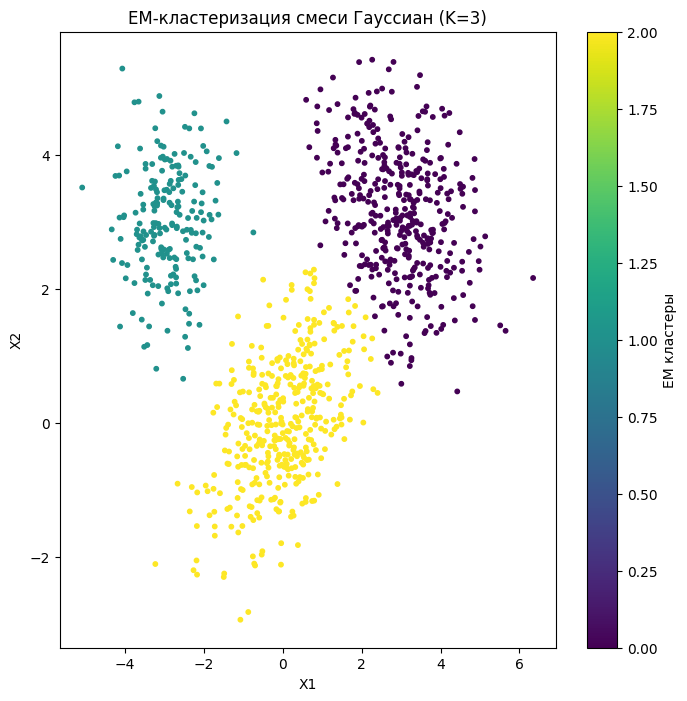

EM кластеризация завершена.
Финальные параметры:
pis: [0.39696886 0.19983948 0.40319166]
mus: [[ 2.94861188  3.14840394]
 [-2.91557445  3.00377114]
 [ 0.03870469  0.03199548]]
sigmas: [[[ 0.93713957 -0.28014675]
  [-0.28014675  0.91949504]]

 [[ 0.44706651  0.02543302]
  [ 0.02543302  0.68844705]]

 [[ 0.97292583  0.48906013]
  [ 0.48906013  0.97527456]]]


In [17]:
# Функции для расчёта плотности Гауссиана и EM-шагов

def multivariate_gaussian_pdf(x, mean, cov):
    """
    Плотность многомерного нормального распределения N(mean, cov)
    x: (D,) вектор
    mean: (D,) среднее
    cov: (D, D) ковариационная матрица
    """
    D = len(mean)
    x_minus_mu = x - mean
    return (1.0 / (np.sqrt((2*np.pi)**D * det(cov)))) * \
           np.exp(-0.5 * x_minus_mu @ inv(cov) @ x_minus_mu)

def e_step(X, pis, mus, sigmas):
    """
    E-шаг: вычисляем gamma_ik = P(z_i = k | x_i)
    Формула:
        gamma_ik = pi_k * N(x_i | mu_k, Sigma_k) / sum_{s=1 to K}[ pi_s * N(x_i | mu_s, Sigma_s) ]
    X: (N, D)
    pis: (K,) доли кластеров pi_k
    mus: (K, D) массив средних
    sigmas: (K, D, D) ковариационные матрицы
    Возвращает G (N, K)
    """
    N, D = X.shape
    K = len(pis)
    G = np.zeros((N, K), dtype=np.float64)

    for i in range(N):
        denominator = 0.0
        for k in range(K):
            G[i, k] = pis[k] * multivariate_gaussian_pdf(X[i], mus[k], sigmas[k])
            denominator += G[i, k]
        # Нормализуем
        if denominator > 0:
            G[i, :] /= denominator
        else:
            # Если denominator ~ 0 (численная проблема),
            # можно оставить равномерно 1/K или 0, но это редкий случай.
            G[i, :] = 1.0 / K
    return G

def m_step(X, G):
    """
    M-шаг: обновляем pi_k, mu_k, Sigma_k
    Формулы:
        pi_k = (1/N) * sum_{i=1 to N} gamma_ik
        mu_k = (1/(N_k)) * sum_{i=1 to N} gamma_ik * x_i
        Sigma_k = (1/N_k) * sum_{i=1 to N} gamma_ik * (x_i - mu_k)(x_i - mu_k)^T
    где N_k = sum_{i=1 to N} gamma_ik
    X: (N, D)
    G: (N, K) — гаммы (апостериорные вероятности)
    Возвращает (pis, mus, sigmas)
    """
    N, D = X.shape
    K = G.shape[1]

    pis = np.zeros(K)
    mus = np.zeros((K, D))
    sigmas = np.zeros((K, D, D))

    for k in range(K):
        N_k = np.sum(G[:, k])  # сумма gamma_ik по i

        # pi_k
        pis[k] = N_k / N

        # mu_k
        if N_k > 0:
            mus[k] = np.sum(G[:, k].reshape(-1, 1) * X, axis=0) / N_k
        else:
            mus[k] = np.zeros(D)

        # Sigma_k
        cov_k = np.zeros((D, D))
        for i in range(N):
            x_minus_mu = (X[i] - mus[k]).reshape(-1,1)
            cov_k += G[i, k] * (x_minus_mu @ x_minus_mu.T)
        if N_k > 0:
            cov_k /= N_k
        else:
            cov_k = np.eye(D)
        sigmas[k] = cov_k

    return pis, mus, sigmas

# Генерация смеси Гауссов (как в задании)
np.random.seed(42)
n_samples = 1000
means_true = [[0, 0], [3, 3], [-3, 3]]
covariances_true = [
    [[1, 0.5], [0.5, 1]],
    [[1, -0.4], [-0.4, 1]],
    [[0.5, 0], [0, 0.75]]
]
weights_true = [0.4, 0.4, 0.2]

X = np.zeros((n_samples, 2))
labels_true = np.zeros(n_samples, dtype=int)
current = 0

for i, (mean, cov, weight) in enumerate(zip(means_true, covariances_true, weights_true)):
    n_cluster_samples = int(n_samples * weight)
    X[current : current + n_cluster_samples, :] = np.random.multivariate_normal(mean, cov, n_cluster_samples)
    labels_true[current : current + n_cluster_samples] = i
    current += n_cluster_samples

# Инициализация K=3 (допустим, мы «знаем» что смесь из 3 гауссиан)
K = 3
N, D = X.shape

# Инициализируем pi_k равномерно
pis = np.ones(K) / K

# Инициализируем mu_k случайным образом из выборки
idx = np.random.choice(N, K, replace=False)
mus = X[idx, :].copy()

# Инициализируем ковариации как единичные матрицы
sigmas = np.array([np.eye(D) for _ in range(K)])

# Цикл EM
max_iter = 100
tol = 1e-5
prev_loglik = None

for iteration in range(max_iter):
    # E-step
    G = e_step(X, pis, mus, sigmas)

    # Вычислим лог-правдоподобие (для отслеживания сходимости)
    log_likelihood = 0.0
    for i in range(N):
        s = 0.0
        for k in range(K):
            s += pis[k] * multivariate_gaussian_pdf(X[i], mus[k], sigmas[k])
        log_likelihood += np.log(s + 1e-12)  # добавляем маленькую константу, чтобы избежать log(0)

    # M-step
    pis, mus, sigmas = m_step(X, G)

    # Критерий сходимости
    if prev_loglik is not None and abs(log_likelihood - prev_loglik) < tol:
        print(f"EM converged at iteration {iteration}, log-likelihood={log_likelihood:.4f}")
        break
    prev_loglik = log_likelihood

# Итоговые апостериорные вероятности G => метки
final_labels = np.argmax(G, axis=1)

# Визуализация итоговой кластеризации EM
plt.figure(figsize=(8,8))
plt.scatter(X[:,0], X[:,1], c=final_labels, cmap='viridis', s=10)
plt.title("EM-кластеризация смеси Гауссиан (K=3)")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="EM кластеры")
plt.show()

# Вывод сравнения: частичное
print("EM кластеризация завершена.\nФинальные параметры:")
print("pis:", pis)
print("mus:", mus)
print("sigmas:", sigmas)

**Бонус [1 Балл].** Заиспользуйте модель GaussianMixture для кластеризации сгенерированной выборки. Мы не проходили GaussianMixture, поэтому для бонусного балла ознакомьтесь с моделью и опишите, как она работает.

In [23]:
gm = GaussianMixture(n_components=3, random_state=42)
gm.fit(X.toarray())

gm_labels = gm.predict(X.toarray())  # То же самое при предсказании
# Получаем кластерные метки
gm_labels = gm.predict(X)

# Визуализация результатов GaussianMixture
plt.figure(figsize=(8, 8))
plt.scatter(X[:,0], X[:,1], c=gm_labels, cmap='viridis', s=10)
plt.title("GaussianMixture Кластеризация (K=3)")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="GMM кластеры")
plt.show()

# Смотрим полученные параметры
print("GMM Weights (pis):", gm.weights_)
print("GMM Means (mus):", gm.means_)
print("GMM Covariances:", gm.covariances_)

KeyboardInterrupt: 